In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch
torch.set_default_dtype(torch.float64)

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.test_functions.synthetic import Ackley

## Single Objective

In [2]:
ackley_1d = Ackley(dim=1, noise_std=0.1, bounds=[([-1., 1.])], negate=True)
ackley_1d_true = Ackley(dim=1, noise_std=0., bounds=[([-1., 1.])], negate=True)

bounds = torch.tensor(ackley_1d._bounds).T

random samples for observations

In [3]:
x1_observed = np.random.uniform(-1, 1, 10).reshape(-1, 1)
x1_observed = torch.tensor(x1_observed)
y1_observed = ackley_1d(x1_observed)

x_dense = np.linspace(-1, 1, 200).reshape(-1, 1)
x_dense = torch.tensor(x_dense)

fitting a single objective GP

In [4]:
gp1 = SingleTaskGP(x1_observed, y1_observed[..., None])
mll1 = ExactMarginalLogLikelihood(gp1.likelihood, gp1)
fit_gpytorch_mll(mll1);

In [5]:
with torch.no_grad():
    gp1_posterior = gp1.posterior(x_dense)

expected_improvement1 = qExpectedImprovement(model=gp1, best_f=y1_observed.max())
# optimized results for acquisition function
qei1 = expected_improvement1(x_dense.unsqueeze(-1).unsqueeze(-1))
candidate1, _ = optimize_acqf(
    expected_improvement1, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

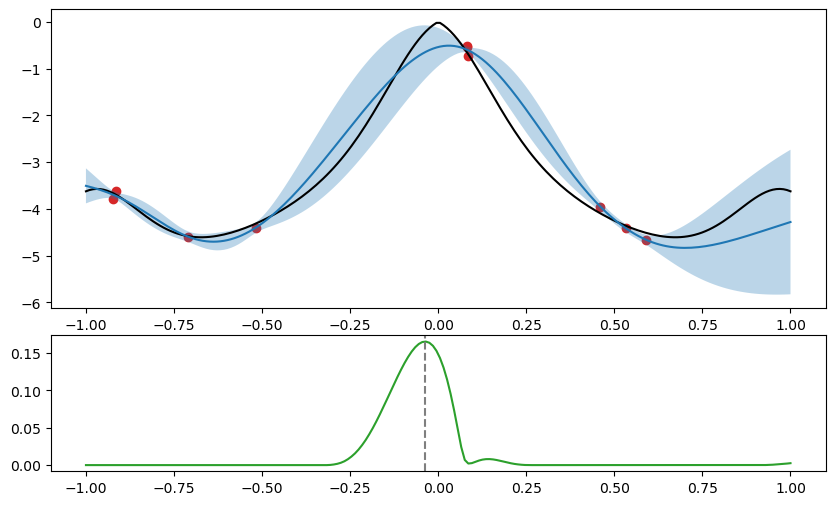

In [6]:
plt.figure(figsize=(10, 6))

ax_func = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax_func.scatter(x1_observed, y1_observed, color='tab:red')
ax_func.plot(x_dense, ackley_1d_true(x_dense), color='k')
ax_func.plot(x_dense, gp1_posterior.mean.detach().numpy())
ax_func.fill_between(
    x_dense.flatten(),
    (gp1_posterior.mean - torch.sqrt(gp1_posterior.variance)).detach().numpy().flatten(),
    (gp1_posterior.mean + torch.sqrt(gp1_posterior.variance)).detach().numpy().flatten(),
    alpha=0.3
)

ax_af = plt.subplot2grid((3, 1), (2, 0))
ax_af.plot(x_dense, qei1.detach().numpy(), color='tab:green')

ax_af.axvline(x=candidate1.detach().numpy().squeeze(), linestyle='--', color='tab:gray');

## Multi-objective (two functions)

Create a slightly shifted version of objective function. In the multi-objective setting, we aim to optimize both original and shifted functions. 

In [7]:
class AckleyShifted(Ackley):
    def __init__(self, dim=2, noise_std=None, negate=False, bounds=None):
        super().__init__(dim, noise_std, negate, bounds)
        
    def forward(self, X):
        return super().forward(X-.2)

In [8]:
ackley_1d_shifted = AckleyShifted(dim=1, noise_std=0.1, bounds=[([-1., 1.])], negate=True)
ackley_1d_shifted_true = AckleyShifted(dim=1, bounds=[([-1., 1.])], negate=True)

x2_observed = np.random.uniform(-1, 1, 10).reshape(-1, 1)
x2_observed = torch.tensor(x2_observed)
y2_observed = ackley_1d_shifted(x2_observed)

Fit another GP.

In [9]:
gp2 = SingleTaskGP(x2_observed, y2_observed[..., None])
mll2 = ExactMarginalLogLikelihood(gp2.likelihood, gp2)
fit_gpytorch_mll(mll2)
with torch.no_grad():
    gp2_posterior = gp2.posterior(x_dense)

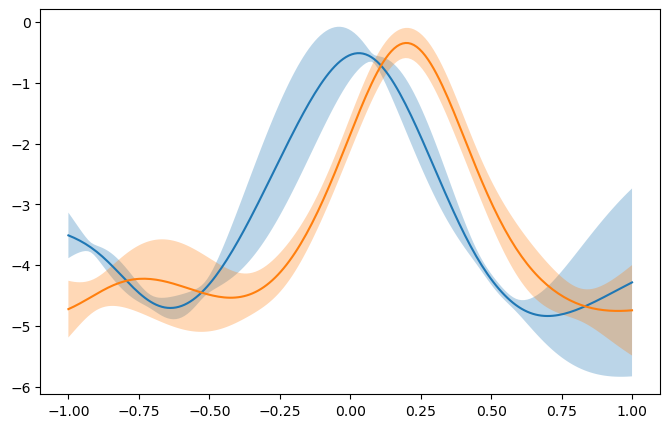

In [10]:
_, ax_func = plt.subplots(1, 1, figsize=(8, 5))
ax_func.plot(x_dense, gp1_posterior.mean.detach().numpy())
ax_func.plot(x_dense, gp2_posterior.mean.detach().numpy())
ax_func.fill_between(
    x_dense.flatten(),
    (gp1_posterior.mean - torch.sqrt(gp1_posterior.variance)).detach().numpy().flatten(),
    (gp1_posterior.mean + torch.sqrt(gp1_posterior.variance)).detach().numpy().flatten(),
    alpha=0.3
)
ax_func.fill_between(
    x_dense.flatten(),
    (gp2_posterior.mean - torch.sqrt(gp2_posterior.variance)).detach().numpy().flatten(),
    (gp2_posterior.mean + torch.sqrt(gp2_posterior.variance)).detach().numpy().flatten(),
    alpha=0.3
);

## MOBO with Expected Hypervolume Improvement

In [11]:
from botorch.optim.optimize import optimize_acqf_list
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.sampling import draw_sobol_samples
from botorch.acquisition.multi_objective.objective import GenericMCMultiOutputObjective, IdentityMCMultiOutputObjective

Use sobol sequence to generate random samples for warm-up. 

In [23]:
x_observed = draw_sobol_samples(bounds=bounds,n=4, q=1).squeeze(1)

y1 = ackley_1d(x_observed)
y2 = ackley_1d_shifted(x_observed)

y_observed = torch.stack([y1, y2]).T
y_observed_true = torch.stack([
    ackley_1d_true(x_observed),
    ackley_1d_shifted_true(x_observed)
]).T

In [13]:
def plot_mobo_obs(model, x_observed, y_observed):
    _, ax_func = plt.subplots(1, 1, figsize=(8, 5))

    with torch.no_grad():
        gp_posterior = model.posterior(x_dense)

    gp_means = gp_posterior.mean.detach().numpy()
    gp_vars = gp_posterior.variance.detach().numpy()

    ax_func.plot(x_dense, gp_means[:, 0], color="tab:blue")
    ax_func.scatter(x_observed, y_observed[:, 0], color="tab:blue")
    ax_func.fill_between(
        x_dense.flatten(),
        (gp_means[:, 0] - np.sqrt(gp_vars[:, 0])).flatten(),
        (gp_means[:, 0] + np.sqrt(gp_vars[:, 0])).flatten(),
        alpha=0.3,
        color="tab:blue"
    )
    ax_func.plot(x_dense, ackley_1d_true(x_dense), '--', color="tab:gray", alpha=.3)
    
    ax_func.plot(x_dense, gp_means[:, 1], color="tab:orange")
    ax_func.scatter(x_observed, y_observed[:, 1], color="tab:orange")
    ax_func.fill_between(
        x_dense.flatten(),
        (gp_means[:, 1] - np.sqrt(gp_vars[:, 1])).flatten(),
        (gp_means[:, 1] + np.sqrt(gp_vars[:, 1])).flatten(),
        alpha=0.3,
        color="tab:orange"
    )
    ax_func.plot(x_dense, ackley_1d_shifted_true(x_dense), '--', color="tab:gray", alpha=.3)
    plt.show()

Pareto plot for first four random samples.

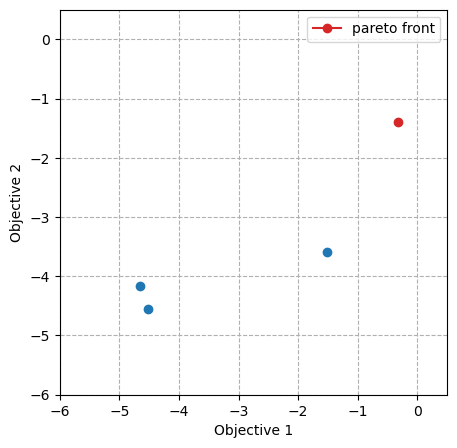

In [14]:
pareto = is_non_dominated(y_observed)

sort_idx = np.argsort(y_observed[pareto][:, 0])

plt.figure(figsize=(5, 5))
plt.plot(*y_observed[pareto][sort_idx].T, '-o', label='pareto front', color='tab:red')
plt.scatter(*y_observed[~is_non_dominated(y_observed)].T)
plt.xlim(-6, .5)
plt.xlabel("Objective 1")
plt.ylim(-6, .5)
plt.ylabel("Objective 2")
plt.grid(linestyle='--')
plt.legend();

For expected hypervolume improvement, we fit a GP for each objective function.

In [15]:
def initialize_model(x_observed, y_observed):
    models = []
    
    for i in range(y_observed.shape[-1]):
        models.append(
            SingleTaskGP(x_observed, y_observed[:, i][..., None])
        )

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

We use `qNoisyExpectedHypervolumeImprovement`, where $q$ is the batch size for quasi-Monte-Carlo (Monte Carlo with low-discrepancy sequences). Here we set $q=4$.

In [16]:
def optimize_qnehvi(model, x_observed):
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=[-6., -6.],
        X_baseline=x_observed,
        prune_baseline=True,
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=4,
        num_restarts=3,
        raw_samples=4,
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True
    )
    new_obj = torch.stack([
        ackley_1d(candidates),
        ackley_1d_shifted(candidates)
    ]).T
    new_obj_true = torch.stack([
        ackley_1d_true(candidates),
        ackley_1d_shifted_true(candidates)
    ]).T
    return candidates, new_obj, new_obj_true

Assume we known the reference point (lower bound of the objectives) already for computing hypervolume.

In [17]:
ref_point = torch.tensor([-6., -6.])
hvs_qnehvi = []

mll_qnehvi, model_qnehvi = initialize_model(x_observed, y_observed)
bd = DominatedPartitioning(ref_point=ref_point, Y=y_observed_true)
volume = bd.compute_hypervolume().item()
hvs_qnehvi.append(volume)

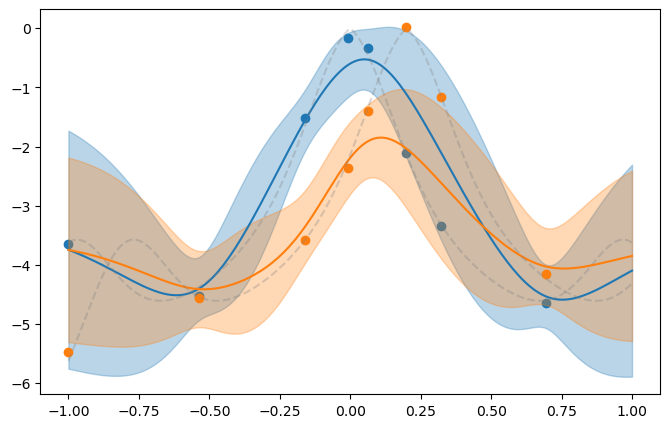

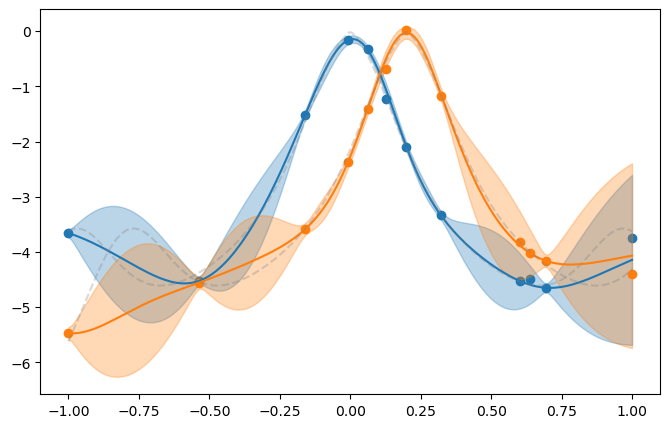

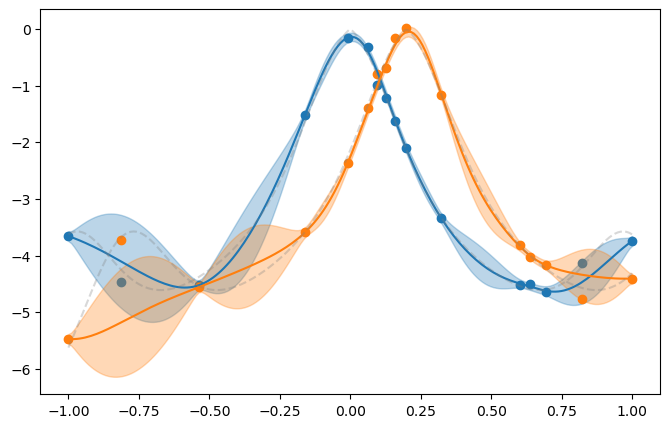

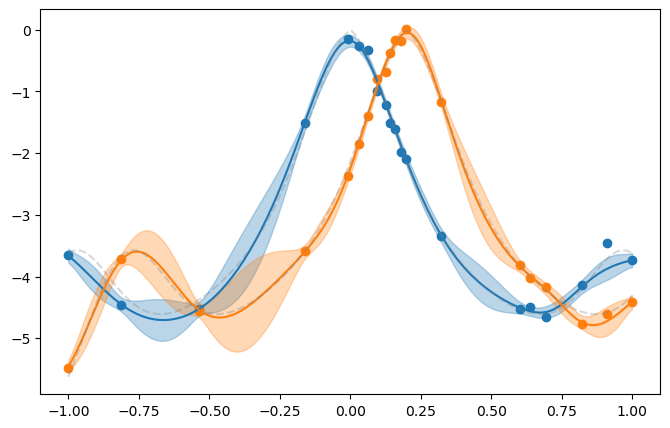

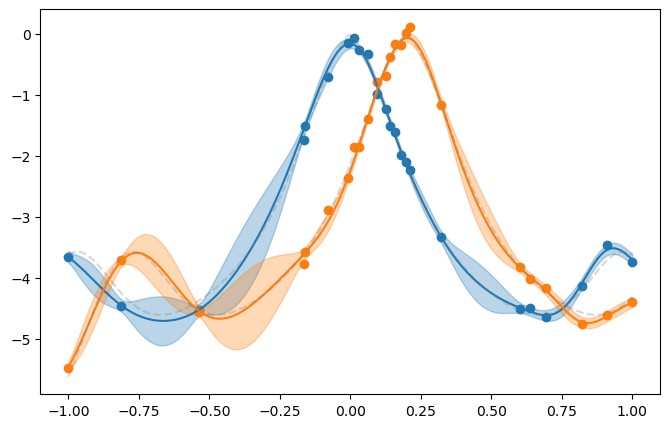

In [18]:
for iterations in range(5):
    fit_gpytorch_mll(mll_qnehvi)
    new_x_qnehvi, new_obj_qnehvi, new_obj_true_qnehvi = optimize_qnehvi(model_qnehvi, x_observed)
    x_observed = torch.cat([x_observed, new_x_qnehvi])
    y_observed = torch.cat([y_observed, new_obj_qnehvi])
    y_observed_true = torch.cat([y_observed_true, new_obj_true_qnehvi])

    bd = DominatedPartitioning(ref_point=ref_point, Y=-y_observed_true)
    volume = bd.compute_hypervolume().item()
    hvs_qnehvi.append(volume)

    plot_mobo_obs(model_qnehvi, x_observed, y_observed)
    mll_qnehvi, model_qnehvi = initialize_model(x_observed, y_observed)

/tmp/ipykernel_3056072/1673339906.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


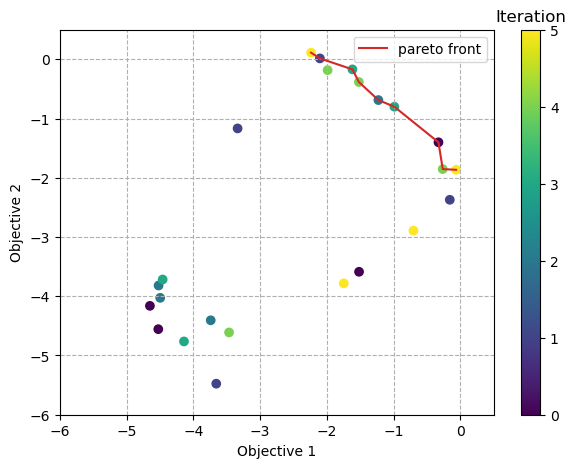

In [19]:
from matplotlib.cm import ScalarMappable

cm = plt.cm.get_cmap('viridis')

pareto = is_non_dominated(y_observed)
sort_idx = np.argsort(y_observed[pareto][:, 0])

num_batch = len(x_observed) / 4
batch_num = np.repeat(np.arange(num_batch), 4)

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(*y_observed[pareto][sort_idx].T, label='pareto front', color='tab:red')
ax.scatter(*y_observed.T, c=batch_num)
ax.set_xlim(-6, .5)
ax.set_xlabel("Objective 1")
ax.set_ylim(-6, .5)
ax.set_ylabel("Objective 2")
ax.grid(linestyle='--')

norm = plt.Normalize(batch_num.min(), batch_num.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
# cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm)
cbar.ax.set_title("Iteration")
plt.legend();